In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [80]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [147]:
import datetime as dt
from datetime import datetime
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Text(0, 0.5, 'Inches')

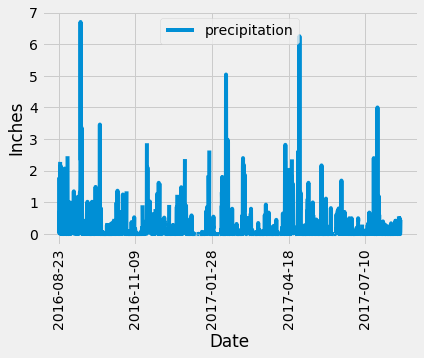

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the last data point in the database.
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [36]:
query_df.head(25)

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45
1188,2016-08-24,1.22
1,2016-08-25,0.08
1007,2016-08-25,0.00
1525,2016-08-25,0.06


In [88]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [74]:
# Design a query to show how many stations are available in this dataset?
query = session.query(Stations.id, 
                      Stations.station).all()#.group_by(Stations.id)
for i in range(len(query)):
    print(query[i][1])

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = session.query(Measurements.station, func.count(Measurements.station)).\
                        group_by(Measurements.station).\
                        order_by(func.count(Measurements.station).desc())

station = query[0][0]
query.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query = session.query(func.min(Measurements.tobs),
                      func.max(Measurements.tobs),
                      func.avg(Measurements.tobs)).\
                      filter(Measurements.station == station)
query.all()[0]

(54.0, 85.0, 71.66378066378067)

Text(0, 0.5, 'Occurences')

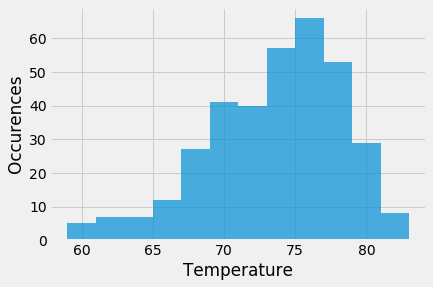

In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurements.tobs).\
                filter(Measurements.station == station).\
                filter(Measurements.date >= prev_year)

temp_df = pd.DataFrame(query)

plt.hist(temp_df['tobs'], bins=12, alpha=.7)
plt.xlabel("Temperature")
plt.ylabel("Occurences")

## Temperature Analysis I

In [97]:
#Identify the average temperature in June at all stations across all available years
#in the dataset. Do the same for December temperature
june = session.query(func.min(Measurements.tobs), 
                             func.max(Measurements.tobs), 
                             func.avg(Measurements.tobs)).\
                             filter(func.strftime("%m", Measurements.date) == "06").all()

december = session.query(func.min(Measurements.tobs), 
                             func.max(Measurements.tobs), 
                             func.avg(Measurements.tobs)).\
                             filter(func.strftime("%m", Measurements.date) == "12").all()

jun = session.query(Measurements.station, func.avg(Measurements.tobs)).\
                             filter(func.strftime("%m", Measurements.date) == "06").\
                             group_by(Measurements.station).all()

dec = session.query(Measurements.station, func.avg(Measurements.tobs)).\
                             filter(func.strftime("%m", Measurements.date) == "12").\
                             group_by(Measurements.station).all()


#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?
#stats.ttest_rel(december[0][2], june[0][2])
jun_df = pd.DataFrame(jun, columns=['stations', 'avg_temp'])
dec_df = pd.DataFrame(dec, columns=['stations', 'avg_temp'])
stats.ttest_rel(jun_df['avg_temp'], dec_df['avg_temp'])


Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

## Temperature Analysis II

In [99]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [103]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2012-03-30', '2012-04-15')
print(trip_temp)

[(61.0, 70.75193798449612, 79.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

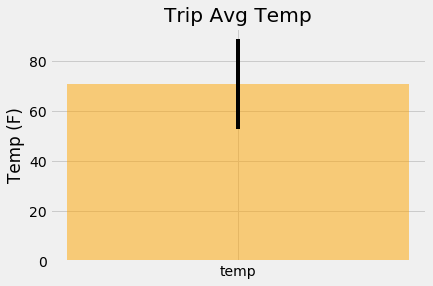

In [141]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x='temp', height=trip_temp[0][1], yerr=[trip_temp[0][2] - trip_temp[0][0]], color="orange", alpha=.5)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')

In [127]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_prcp(start_date, end_date):
    
    query = session.query(Measurements.station,
                          Stations.name,
                          Stations.longitude,
                          Stations.latitude,
                          Stations.elevation,
                          func.sum(Measurements.prcp)).\
                          filter(Measurements.date >= start_date).\
                          filter(Measurements.date <= end_date).\
                          filter(Measurements.station == Stations.station).\
                          group_by(Measurements.station).order_by(func.sum(Measurements.prcp).desc()).all()
    
    
    
    return query

results = calc_prcp('2012-03-30', '2012-04-15')
for result in results:
    print(result)



('USC00516128', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 152.4, 9.24)
('USC00519281', 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 32.9, 2.6399999999999997)
('USC00513117', 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6, 0.6100000000000001)
('USC00519397', 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0, 0.44000000000000006)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 19.5, 0.34)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', -157.9992, 21.3152, 0.9, 0.32)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', -158.0111, 21.4992, 306.6, 0.3)
('USC00517948', 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9, 0.21000000000000002)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 7.0, 0.21000000000000002)


In [126]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [182]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2012-03-30' 
end   = '2012-04-15'   

start = datetime.strptime(start, '%Y-%m-%d')
end = datetime.strptime(end, '%Y-%m-%d')

# Use the start and end date to create a range of dates
delta = end - start

list_dates = []

for i in range(delta.days + 1):
    day = start + timedelta(days=i)
    list_dates.append(day.date())

# Strip off the year and save a list of %m-%d strings
list_dates_strip = [date.strftime("%m-%d") for date in list_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in list_dates_strip:
    normals.append(daily_normals(date))

normals_unlist = []
for normal in normals:
    normals_unlist.append(normal[0])
normals = normals_unlist

In [184]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, index=list_dates_strip, columns=["temp_min", "temp_avg", "temp_max"])
normals_df.head(25)

,temp_min,temp_avg,temp_max
03-30,62.0,72.175439,79.0
03-31,61.0,71.875000,79.0
04-01,60.0,71.879310,80.0
04-02,53.0,71.821429,79.0
04-03,55.0,72.228070,78.0
04-04,58.0,72.016393,78.0
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0


Text(0, 0.5, 'Temperature')

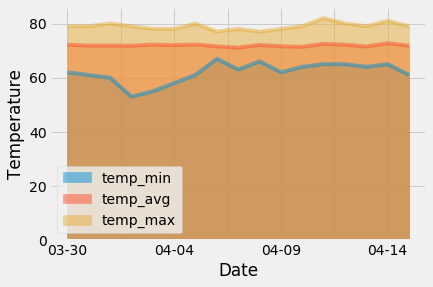

In [188]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
